In [7]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langsmith import traceable
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated,TypedDict,Literal,Dict,List,Any,Optional
from pydantic import BaseModel,Field
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage,BaseMessage
from dotenv import load_dotenv
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent,tools_condition,ToolNode
from finnhub import Client
from langchain_core.tools import tool
from langgraph_supervisor import create_supervisor,create_handoff_tool
from datetime import datetime,timedelta
from sec_api import QueryApi
import requests
from yfinance import Ticker
import pandas as pd
from sec_edgar_api import EdgarClient
import yfinance as yf
import json
import pandas_ta as ta
import os
import aiohttp
import sqlite3
import requests
load_dotenv()


True

In [2]:
model=ChatGroq(api_key=os.getenv("GROQ"),model="llama3-8b-8192")

In [3]:

class Sentiment(BaseModel):
    sentiment:Literal['positive','negative','neutral']=Field(...,description="you need to classify the sentiment of the message based on the analysis")
    reason:str =Field(...,description="you need to give the reason for the sentiment classification")
    overall_factors:Dict[str,str]=Field(...,description="Factors influencing the sentiment in which the key is sentiment and reason is the value")

In [4]:
class reason_setiment(BaseModel):
    overall_sentiment:Literal['positive','negative','neutral']=Field(...,description="you need to classify the sentiment of the message based on the analysis")
    analysis: Annotated[List, Field(min_items=1, description="List of bullet points explaining the sentiment classification.")] 


In [5]:
model2_wstr_output=model.with_structured_output(reason_setiment)

In [6]:
model_with_structure=model.with_structured_output(Sentiment)

In [7]:
class StockAgent(TypedDict):
    ticker:str
    message:Annotated[list,add_messages]

In [8]:
def search_web(query:str):
   ''' Searches the web for the given query and returns the top 10 results '''
   tavily=TavilySearchResults(max_results=20,api_key=os.getenv('TAVILY_API_KEY'))
   return tavily.invoke(query)


In [9]:
import os
from sec_api import QueryApi # Changed from EdgarClient
from bs4 import BeautifulSoup
import requests # Added import

# IMPORTANT: The SEC API requires you to set a User-Agent.
# Replace 'Your Name' and 'your.email@example.com' with your actual info.
os.environ['EDGAR_USER_AGENT'] = 'Divy yadavdipu296@gmail.com'
@tool(description="Fetches the full text of the most recent 10-K filing for a given company ticker using sec_api.QueryApi.")
def get_latest_10k_filing(ticker: str) -> str:
    """
    Fetches the full text of the most recent 10-K filing for a given company ticker using sec_api.QueryApi.

    Args:
        ticker: The company's stock ticker (e.g., "TSLA").

    Returns:
        The plain text content of the 10-K filing's primary document.
        Returns an error message if the filing cannot be fetched.
    """
    print(f"---  SEC TOOL: Fetching latest 10-K for {ticker} ---")
    try:
        # Initialize QueryApi with your SEC API key
        query_api = QueryApi(api_key=os.getenv('SEC_API_KEY')) # Assumes SEC_API_KEY in .env

        # Query for the latest 10-K filing for the ticker
        query = {
        "query": {"query_string": {"query": f'ticker:{ticker} AND formType:"10-K"'}},
        "from": 0,
        "size": 1,
        "sort": [{"filedAt": {"order": "desc"}}],
    }
        response = query_api.get_filings(query=query)
        
        if not response or not response.get("filings"):
            return f"Error: No 10-K filings found for ticker {ticker}."

        # Get the URL of the primary document from the latest filing
        filing_url = response["filings"][0].get("linkToHtml")
        
        if not filing_url:
            return f"Error: Could not find a filing URL for {ticker}."

        # Fetch the content of the filing URL using requests
        filing_html = requests.get(filing_url, headers={'User-Agent': os.getenv('EDGAR_USER_AGENT')}).text

        # Use BeautifulSoup to parse the HTML and extract all text
        soup = BeautifulSoup(filing_html, 'html.parser')
        plain_text = soup.get_text(separator='\n', strip=True)

        print(f"--- SEC TOOL: Successfully fetched and parsed 10-K for {ticker}. ---")
        return plain_text

    except Exception as e:
        return f"An error occurred while fetching the SEC data: {e}"

In [10]:
@tool(description="Searches the web for the the ticker and gives the result sentiment with analysis")
def analyze_news_sentiment(ticker:str,days_back:int=30)-> Dict[str, Any]:
                    """
                    Analyzes recent news sentiment for a given company ticker over a specified period.
                    
                    Args:
                        ticker: The company's stock ticker (e.g., "TSLA").
                        days_back: Number of days to look back for news articles (default: 30).
                        
                    Returns:
                        A dictionary containing news sentiment analysis.
                    """
                    try:
                        end_date=datetime.now()
                        start_date=end_date-timedelta(days=days_back)
                        search_query = f"{ticker} company news from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')} of its performances and changes"
                        news_result= search_web(search_query)
                        if not news_result:
                            return {'error':f" no articles found for the ticker {ticker} for the specific period"}
                        news_text=''
                        for i,result in enumerate(news_result[:10],1):
                            news_text += f"Article {i}: {result.get('title', 'No title')}\n"
                            news_text += f"Content: {result.get('content', 'No content')[:200]}...\n\n"
                    except Exception as e:
                        raise {'error':f"An error occurred while fetching news articles: {e}"}
                    sentiment_result=model_with_structure.invoke(news_text)
                    prompt=f"based on the {sentiment_result} provide a summary of the news sentiment with detailed reasons from the news text"
                    final_sentiment_with_reason=model2_wstr_output.invoke(prompt)
                    return final_sentiment_with_reason

In [37]:
@tool(description="gets the info of the particular companys overall functions")
def company_overview(ticker:str):
    '''gets the info of the particular companys overall functions with all the metrics of the company'''
    api=os.getenv('Alpha_Vantage_Stock_API')
    if not api:
        return {'API KEY IS MISSING'}
    try:
        url=f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={ticker}&apikey={api}'
        response=requests.get(url)
        response.raise_for_status() 
        data=response.json()
        if "Note" in data or not data:
                return {"error": f"Could not fetch data for {ticker}. The API limit may be reached or the ticker is invalid."}

        return data
    except Exception as e:
        return {'error':f"An error occurred while fetching the data: {e}"}
    except requests.exceptions.RequestException as e:
        return {'error':f"An error occurred while fetching the data: {e}"}


In [42]:

@tool(description='gets the insider infor of the company')
def get_insider_info(ticker:str):
        ''' returns the latest and historical insider transactions made by key stakeholders (e.g., founders, executives, board members, etc.) of a specific company.'''

        api=os.getenv('Alpha_Vantage_Stock_API')
        if not api:
           return {'API KEY IS MISSING'}
        url=f'https://www.alphavantage.co/query?function=INSIDER_TRANSACTIONS&symbol={ticker}&apikey={api}'
        try:
            response=requests.get(url)
            response.raise_for_status()
            data=response.json()
            if "Note" in data or not data:
                return {"error": f"Could not fetch data for {ticker}. The API limit may be reached or the ticker is invalid."}
            return data
        except Exception as e:
            return {'error':f"An error occurred while fetching the data: {e}"}
        except requests.exceptions.RequestException as e:
            return {'error':f"An error occurred while fetching the data: {e}"}

        
@tool(description='does advanced analytics details of the company')
def advaced_analyst(ticker:list[str],
    interval: str,
    window_size: int,
    calculations: List[str],
    range_str: str,
    ohlc: Optional[str] = "close"
):
        ''' This endpoint returns a rich set of advanced analytics metrics (e.g., total return, variance, auto-correlation, etc.) for a given time series over sliding time windows. For example, we can calculate a moving variance over 5 years with a window of 100 points to see how the variance changes over time.'''
        api=os.getenv('Alpha_Vantage_Stock_API')
        if not api:
               return {"error": "Alpha Vantage API key not found."}
            
        base_url="https://www.alphavantage.co/query"
        params={
            "function": "ANALYTICS_SLIDING_WINDOW",
            'SYMBOLS':ticker,
            "RANGE": '6month',
            "INTERVAL": interval,
            "WINDOW_SIZE": window_size,
            "CALCULATIONS": ",".join(calculations),
            "OHLC": ohlc,
            "apikey": api
        }
            
        try:
            # Use the list of tuples for the request parameters
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()

            if "Note" in data or not data:
                return {"error": "Could not fetch data. API limit may be reached or parameters are invalid."}
            
            return data.get("payload", {"error": "No payload found."})

        except requests.exceptions.RequestException as e:
            return {"error": f"An API request error occurred: {e}"}
        except Exception as e:
            return {"error": f"An unexpected error occurred: {e}"}

In [ ]:
@tool(description="Fetches the current market status for a given exchange using the Finnhub API.")
def get_market_status(exchange: str) -> str:
    ''' Fetches the current market status for a given exchange using the Finnhub API.'''
    try:
        finnhub_client = Client(api_key=os.getenv("FINNHUB_API_KEY"))
        get_market_status=finnhub_client.market_status(exchange='US')
        return get_market_status
    except Exception as e:
        return {"error": f"An unexpected error occurred: {e}"}
    
def get_insiders_sentiment(ticker: str) -> Dict[str, Any]:
    '''Fetches insider sentiment data for a given stock ticker within a specified date range.'''
    try:
        finnhub_client = Client(api_key=os.getenv("FINNHUB_API_KEY"))
        end_date = datetime.now().strftime('%Y-%m-%d')
        start_date = (datetime.now() - timedelta(days=90)).strftime('%Y-%m-%d')

        sentiment_data = finnhub_client.stock_insider_sentiment(ticker, start_date, end_date)
        if not sentiment_data or 'data' not in sentiment_data:
            return {"message": f"No insider sentiment data found for {ticker} in the last 90 days."}
        total_mspr=sum(item['mspr'] for item in sentiment_data['data'])
        sentiment_score = "Positive" if total_mspr > 0 else "Negative" if total_mspr < 0 else "Neutral"

        return {
            "ticker": ticker,
            "monthly_sentiment_score_mspr": total_mspr,
            "overall_sentiment": sentiment_score
        }

    except Exception as e:
        return {"error": f"An unexpected error occurred: {e}"}

        
    

In [41]:
@tool(description="Use this tool to get the current date.")
def get_current_date() -> str:
    """Returns the current date in YYYY-MM-DD format."""
    return datetime.now().strftime('%Y-%m-%d')

In [14]:

@tool(description="""
    Use this tool to get key technical indicators (RSI, 50-day SMA, 200-day SMA) 
    for a given stock ticker. The input MUST be a single company stock ticker.
    For example: 'AAPL' or 'TSLA'.
""")
def get_technichal_analysis(ticker: str) -> Dict[str, Any]:
        """
        Fetches historical stock data and calculates key technical indicators.
        Returns a dictionary with the current price and indicators, or an error message.
        """
        print(f"--- TECHNICAL TOOL: Performing full analysis for {ticker} ---")
        try:
            stock=yf.Ticker(ticker)
            hist = stock.history(period="1y")
            
            if hist.empty:
                return f"Error: No historical data found for ticker {ticker}."
            
            hist.columns=[col.capitalize() for col in hist.columns]
            
            #calculating metrics
            hist.ta.rsi(append=True)
            hist.ta.sma(length=50, append=True)
            hist.ta.sma(length=200, append=True)

            if 'RSI_14' not in hist.columns or 'SMA_50' not in hist.columns or 'SMA_200' not in hist.columns:
                      return {"error": f"Could not calculate all technical indicators for {ticker}. Not enough data."}
            latest_indicators = {
            "current_price": hist['Close'].iloc[-1],
            "rsi": hist['RSI_14'].iloc[-1],
            "sma_50": hist['SMA_50'].iloc[-1],
            "sma_200": hist['SMA_200'].iloc[-1]
        }

            for key,value in latest_indicators.items():
                if pd.isna(value):
                    return {"error": f"Could not calculate {key} for {ticker}. Not enough data."}
                return latest_indicators
                
        except Exception as e:
            return f"An error occurred while fetching the technical analysis: {e}"


In [ ]:

class InvestmentAgentState(TypedDict):
    """
    The central state for the entire investment analysis workflow.
    """
    # --- Inputs ---
    ticker: str

    # --- Agent Outputs ---
    # A place to store the result from each specialized agent
    financial_analysis: Optional[Dict]
    news_analysis: Optional[Dict]
    technical_analysis: Optional[Dict]

    # --- Final Result ---
    # The final, user-facing investment report
    final_report: Optional[str]

    # The message history for the agentic communication
    messages: Annotated[list, add_messages]

In [16]:
def investment_strategist_node(state: InvestmentAgentState) -> Dict:
    """
    The final node in the graph. Synthesizes all analysis into a final report.
    """
    print("--- 🧠 EXECUTING INVESTMENT STRATEGIST ---")
    
    ticker = state['ticker']
    financial_summary = state.get('financial_analysis', "No data provided.")
    news_summary = state.get('news_analysis', "No data provided.")
    technical_summary = state.get('technical_analysis', "No data provided.")

    # The meta-prompt to guide the final synthesis
    investment_strategist_prompt = f"""
    You are a Senior Investment Portfolio Manager. You have received three reports from your junior analysts: a financial analysis from SEC filings, a market news and sentiment analysis, and a technical stock analysis.

    Your task is to synthesize these findings into a final, professional investment thesis report.

    Here are the reports from your team:

    **1. Financial Analysis Report:**
    {financial_summary}

    **2. News & Sentiment Analysis Report:**
    {news_summary}

    **3. Technical Analysis Report:**
    {technical_summary}

    ---

    **Your Final Report Structure:**

    You must structure your final report in Markdown format with the following sections:

    **## Investment Thesis for {ticker}**

    **### 1. Executive Summary & Recommendation**
    * Provide a brief, high-level overview of the investment thesis.
    * **Crucially, you must conclude this section with a clear, one-word recommendation: `BUY`, `HOLD`, or `AVOID`.**

    **### 2. Fundamental Analysis**
    * Summarize the key findings from the financial (10-K) analysis. Discuss revenue, profitability, and any significant risk factors mentioned in the filing.

    **### 3. Market Sentiment Analysis**
    * Summarize the findings from the news analysis. Discuss the overall sentiment (Positive/Negative/Neutral) and the key news events driving that sentiment.

    **### 4. Technical Analysis**
    * Summarize the findings from the technical analysis. Discuss the stock's current price relative to its key moving averages and what the RSI indicates about its momentum.

    **### 5. Final Justification**
    * Provide a concluding paragraph that justifies your `BUY/HOLD/AVOID` recommendation by weighing the evidence from all three reports.

    ---

    Now, generate the complete investment thesis report for {ticker}.
    """
    
    # Generate the final report using the model
    final_report = model.invoke(investment_strategist_prompt).content
    
    # Update the state with the final report
    return {
        "final_report": final_report
    }

In [ ]:
handoff_to_quant_analyst_tool = create_handoff_tool(
    agent_name="quantitative_analyst",
    description="Use this to delegate the task of performing quantitative analysis, such as calculating historical volatility and mean returns."
)

In [ ]:
# 1. Junior Agents (Specialized Analysts)
financial_analyst = create_react_agent(
    model=model,
    tools=[get_latest_10k_filing,company_overview],
    name='financial_analyst',
    prompt='''You are a Senior Financial Analyst. Your job is to:
    1. Fetch and analyze the latest 10-K filing
    2. Extract key financial metrics, risk factors, and business insights
    3. Provide a structured financial summary
    4. Be thorough but concise - senior analysts will review your work''',

)

news_analyst = create_react_agent(
    model=model,
    tools=[search_web, analyze_news_sentiment],
    name='news_analyst',
    prompt='''You are a Junior News Analyst. Your job is to:
    1. Search for recent news about the given ticker
    2. Analyze sentiment and identify key drivers
    3. Provide market sentiment score and news summary
    4. Be objective and data-driven'''
)

technical_analyst_manager = create_react_agent(
    model=model,# Will add yfinance tools later
    name='technical_analyst',
    tools=[get_technichal_analysis,handoff_to_quant_analyst_tool],
    prompt='''You are a Junior Technical Analyst. Your job is to:
    1. Analyze stock price data and technical indicators
    2. Identify trends, support/resistance levels, and momentum
    3. Provide technical outlook with confidence level
    4. Note: Currently placeholder - will add stock data tools'''
)

# 2. Senior Supervisor Agent (Portfolio Manager)
# Create supervisor that can hand off to specialized agents
supervisor = create_supervisor(
    model=model,
    agents=[  
        financial_analyst,
        news_analyst,
        technical_analyst_manager
    ],
    prompt='''You are a Senior Investment Portfolio Manager.
    
    You have three junior analysts working for you:
    1. Financial Analyst - analyzes SEC filings
    2. News Analyst - analyzes market sentiment
    3. Technical Analyst - analyzes stock price data
    
    Your workflow:
    1. Delegate tasks to appropriate junior analysts
    2. Review their work for quality and completeness
    3. Synthesize findings into final investment recommendation
    4. Ensure all analysis is thorough and professional
    
    Always maintain oversight and validate junior analysts' work.'''
)


In [ ]:
# The specialist agent for quantitative analysis
quantitative_analyst = create_react_agent(
    model=model,
    tools=[advaced_analyst],
    name='quantitative_analyst',
    prompt='''You are a specialist  Quantitative Analyst. Your only job is to use your tool
    to perform a standard quantitative analysis on a stock's performance over a 6-month period.

    You MUST call the `get_analytics_sliding_window` tool with the `range_str` parameter set to "6month".
    
    After getting the data, provide a concise summary of the mean return and the annualized standard deviation (volatility)
    and .'''
)
##

In [ ]:

def run_agent(agent,agent_name:str,state:InvestmentAgentState,key_to_update:str):
    result=agent.invoke(state['messages'])
    return {key_to_update:result.content, "messages": state["messages"] + [AIMessage(content=str(result), name=agent_name)]}

def financial_agent(state: InvestmentAgentState):
    return run_agent(financial_analyst,'financial_analyst',state,'financial_analysis')

def news_agent(state: InvestmentAgentState):
    return run_agent(news_analyst,'news_analyst',state,'news_analysis')

def technical_agent(state: InvestmentAgentState):
    return run_agent(technical_analyst_manager,'technical_analyst',state,'technical_analysis')

def supervisor(state: InvestmentAgentState):
    return run_agent(supervisor,'supervisor',state,'supervisor')

In [19]:
# Define the graph
workflow = StateGraph(InvestmentAgentState)

# Add the nodes for each junior agent
workflow.add_node("financial_analyst", financial_agent)
workflow.add_node("news_analyst", news_agent)
workflow.add_node("technical_analyst", technical_agent)
workflow.add_node("investment_strategist", investment_strategist_node)

# The supervisor is the central router
workflow.add_node("supervisor", supervisor)

# Define the edges. After each junior agent runs, it reports back to the supervisor.
workflow.add_edge("financial_analyst", "supervisor")
workflow.add_edge("news_analyst", "supervisor")
workflow.add_edge("technical_analyst", "supervisor")

# The supervisor decides which agent to run next, or if it's time to synthesize.
workflow.add_conditional_edges(
    "supervisor",
    # The supervisor's output will be the name of the next agent to run
    # or "FINISH" when the analysis is complete.
    lambda x: x["messages"][-1].name,
    {
        "financial_analyst": "financial_analyst",
        "news_analyst": "news_analyst",
        "technical_analyst": "technical_analyst",
        # If the supervisor says "FINISH", we route to the strategist
        "FINISH": "investment_strategist",
    },
)

# The strategist is the final step before the end.
workflow.add_edge("investment_strategist", END)

# The entry point of the entire graph is the supervisor.
workflow.set_entry_point("supervisor")

# Finally, compile the graph into a runnable object.
graph = workflow.compile()

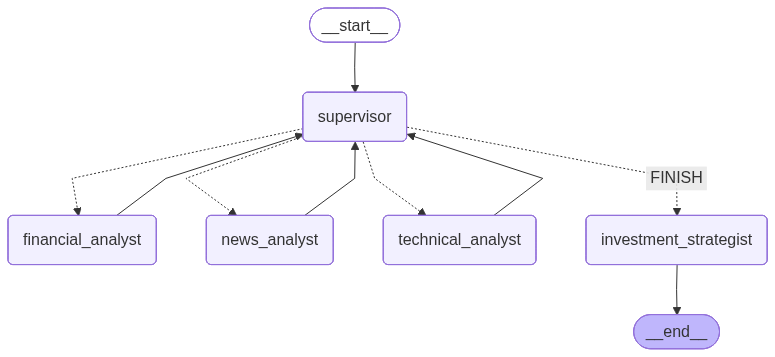

In [20]:
graph